In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as roc_auc_score
import matplotlib as mpl
import sys
import os
import math
from pathlib import Path

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

$
\begin{aligned}
& \frac{1}{T}\sum_{t, l} w_{t,l} A(c|\alpha_{t,l}) B_1(x_1|\beta_{t,l}) B_2(x_2|\gamma_{t,l}) \\
\end{aligned}
$

In [22]:
def process_data(file, y_labels, x_labels, ndata, test=False, oldfiles=False):
    # Read data
    #df = pd.DataFrame(columns = x_labels)
    ndata_per_file = 1000
    if oldfiles:
        niter = 1
    else:
        niter = math.ceil(ndata/ndata_per_file)
    for j in range(niter):
        if oldfiles:
            data = h5py.File(f"{file}_inferred.h5", "r")
            temp_df = pd.DataFrame(columns = x_labels)
        else:
            if ndata_per_file*(j+1) < ndata:
                data = h5py.File(f"{file}_{ndata_per_file*j + 1}-{ndata_per_file*(j+1)}_inferred.h5", "r")
            else:
                data = h5py.File(f"{file}_{ndata_per_file*j + 1}-{ndata}_inferred.h5", "r")
            temp_df = pd.DataFrame(columns = x_labels)
        for i in range(len(x_labels)):
            temp_df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
    
        if ("x1" in x_labels):
            temp_df = cartesian_to_polar_df(temp_df, "x1", "x2", "r", "a1")

        elif ("r" in x_labels):
            temp_df = polar_to_cartesian_df(temp_df, "x1", "x2", "r", "a1")

        #df["Confidence"] = data["confidence"]
        for i in range(len(y_labels)):
            temp_df[f"Est_prob_{y_labels[i]}"] = data["probabilities"][:,i]
            if oldfiles:
                temp_df[f"Std_prob_{y_labels[i]}"] = np.std(np.array(data["samples"][:, :, i]), axis=-1)
            else:
                temp_df[f"Std_prob_{y_labels[i]}"] = data["stds"][:,i]
            
        # Get truth label values (annoying because text is not read as text, should fix)
        # Is fixed, just update
        if (test == False):
            temp_df["class"] = data["truth"]
            temp_df["Truth_label"] = y_labels[0]
            c1 = 1.0
            df_copy = temp_df.copy()
            mask = df_copy["class"] == c1
            temp_df.loc[mask, "Truth_label"] = y_labels[1]
        
        # Get 25-75% error bars
        for i in range(len(y_labels)):
            temp_df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
            temp_df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
            temp_df[f"Error_{y_labels[i]}"] = (temp_df[f"quantile75_{y_labels[i]}"] - temp_df[f"quantile25_{y_labels[i]}"])/2
        # Concat files
        if j == 0:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], ignore_index=True)
    # Could be some NaNs
    len_nan = len(df[df.isnull().any(axis=1)])
    if len_nan > 0:
        print(f"Dropping {len_nan} rows of NaNs")
        df = df.dropna()

    # Get inferred color
    df["Argmax"] = df[[f"Est_prob_{y_labels[0]}", f"Est_prob_{y_labels[1]}"]].idxmax(axis=1)
    df["Prediction"] = 0 # red
    df_copy = df.copy()
    mask = df_copy["Argmax"] == f"Est_prob_{y_labels[1]}"
    df.loc[mask, "Prediction"] = 1
    
    return df

In [4]:
# Custom plot function
def plot_distributions(df):

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    # Plot 2D data points
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=axs[0][0])
    df_c1 = df[df["color"] == "blue"]
    sn.scatterplot(df_c1, x="x1", y = "x2", c="blue", alpha=0.1, ax=axs[1][0])
    axs[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    axs[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot angular distribution
    sn.histplot(df_red, x="a_x", color="red", ax=axs[0][1])
    sn.histplot(df_c1, x="a_x", color="blue", ax=axs[1][1])
    axs[0][2].set_xlabel(r"$\theta_x$")
    axs[1][2].set_xlabel(r"$\theta_x$")

    # Plot radial distribution
    sn.histplot(df_red, x="r_x", color="red", ax=axs[0][2])
    sn.histplot(df_c1, x="r_x", color="blue", ax=axs[1][2])
    axs[0][2].set_xlabel(r"$|\vec{x}|$")
    axs[1][2].set_xlabel(r"$|\vec{x}|$")
    axs[0][2].set_xlim(0, 25)
    axs[1][2].set_xlim(0, 25)

    # Ticks
    for ax in axs.flatten():
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()

    return fig, ax

### Setup and constants

In [39]:
# Setup

#MCMC constants
n_samples = 1200
#n_data = [250, 5000]
beta_hyperparam = 1

#n_data = [250, 1000]
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
#n_data = [250, 500, 1000, 2000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
n_chains = [10, 10, 10, 10]
n_plots = len(n_data)

#Data constants
dataset = "A"
if dataset == "A":
    shapes = [2, 6]
    scales = [5, 3]
elif dataset == "B":
    shapes = [2, 4]
    scales = [3, 3]
elif dataset == "C":
    shapes = [6, 6]
    scales = [3, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Data labels
polar = False
y_labels = ["c0", "c1"]
if polar:
    x_labels = ["r", "a1"]
else:
    x_labels = ["x1", "x2"]

# Read files
folderpath = "inference"
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"
large_gridfile = f"grid_r_a1_2500_{tag}"

if polar:
    analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains[i]}_ndata-{n_data[i]}_POLAR" for i in range(n_plots)]
else:
    if beta_hyperparam == 1:
        analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains[i]}_ndata-{n_data[i]}" for i in range(n_plots)]
        #analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains[i]}_ndata{n_data[i]}_ncomps_300" for i in range(n_plots)]
    else:
        analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains[i]}_ndata-{n_data[i]}_Beta_{beta_hyperparam}_{beta_hyperparam}" for i in range(n_plots)]
#valfiles = [f"{folderpath}/{folder}/{valfile}_inferred.h5" for folder in analysis_folders]
#testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
#gridfiles = [f"{folderpath}/{folder}/{gridfile}_inferred.h5" for folder in analysis_folders]
#large_gridfiles = [f"{folderpath}/{folder}/{large_gridfile}_inferred.h5" for folder in analysis_folders]

testfiles = [f"{folderpath}/{folder}/{testfile}" for folder in analysis_folders]
gridfiles = [f"{folderpath}/{folder}/{gridfile}" for folder in analysis_folders]
large_gridfiles = [f"{folderpath}/{folder}/{large_gridfile}" for folder in analysis_folders]

train_data = pd.read_csv(f"../data/{trainfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
large_grid_data = pd.read_csv(f"../data/{large_gridfile}.csv")

grid_rmax = grid_data["x1"].max()
print(grid_rmax)
large_grid_rmax = large_grid_data["r"].max()

if beta_hyperparam == 1:
    grid_dfs = [process_data(file, y_labels, x_labels, 10000, test=True, oldfiles=False) for file in gridfiles]
    large_grid_dfs = [process_data(file, y_labels, x_labels, 2500, test=True, oldfiles=False) for file in large_gridfiles]
    test_dfs = [process_data(file, y_labels, x_labels, 10000, test=False, oldfiles=False) for file in testfiles]
else:
    grid_dfs = [process_data(file, y_labels, x_labels, 10000, test=True, oldfiles=False) for file in gridfiles]
    large_grid_dfs = [process_data(file, y_labels, x_labels, 2500, test=True, oldfiles=False) for file in large_gridfiles]
    #test_dfs = [process_data(file, y_labels, x_labels, 10000, test=False, oldfiles=True) for file in testfiles]

for i in range(len(n_data)):
    if (not os.path.isdir(f"predictions/{trainfile}") ):
        os.mkdir(f"predictions/{trainfile}")
    if beta_hyperparam == 1:
        test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_MM_ndata-{n_data[i]}.csv")
        grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_MM_ndata-{n_data[i]}.csv")
        large_grid_dfs[i].to_csv(f"predictions/{trainfile}/large_grid_{tag}_predicted_MM_ndata-{n_data[i]}.csv")
    else:
        #test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_MM_ndata-{n_data[i]}_Beta_{beta_hyperparam}_{beta_hyperparam}.csv")
        grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_MM_ndata-{n_data[i]}_Beta_{beta_hyperparam}_{beta_hyperparam}.csv")
        large_grid_dfs[i].to_csv(f"predictions/{trainfile}/large_grid_{tag}_predicted_MM_ndata-{n_data[i]}_Beta_{beta_hyperparam}_{beta_hyperparam}.csv")

50.05551275463989


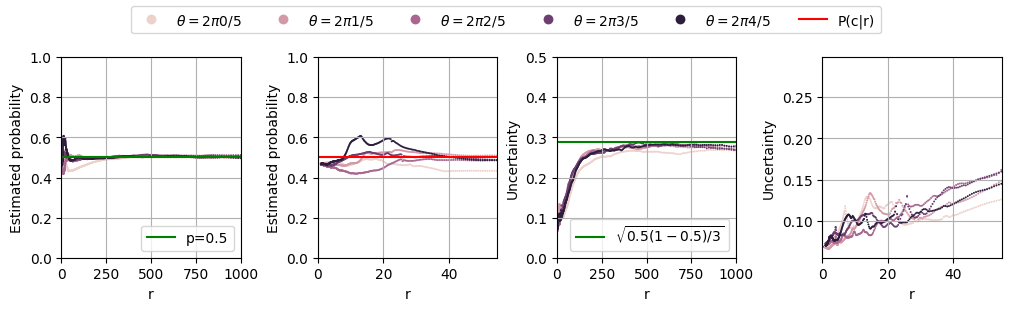

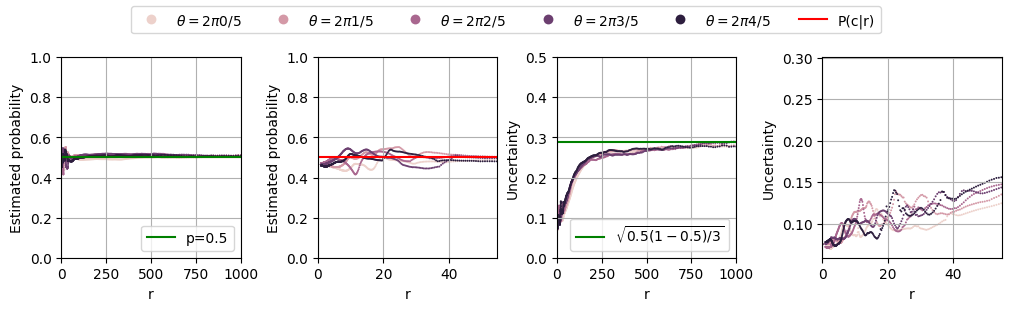

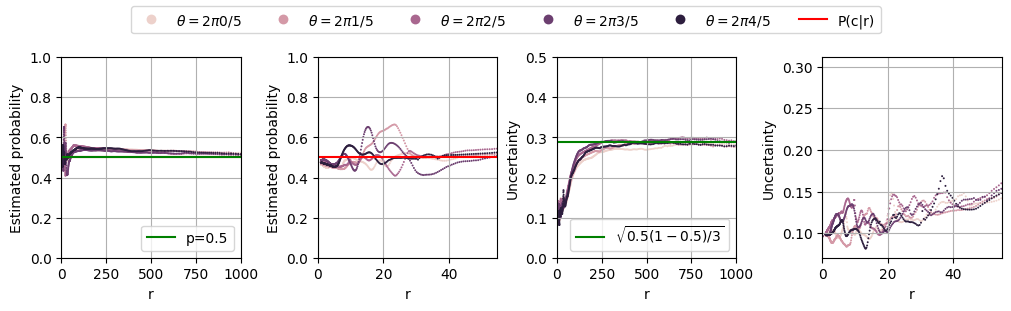

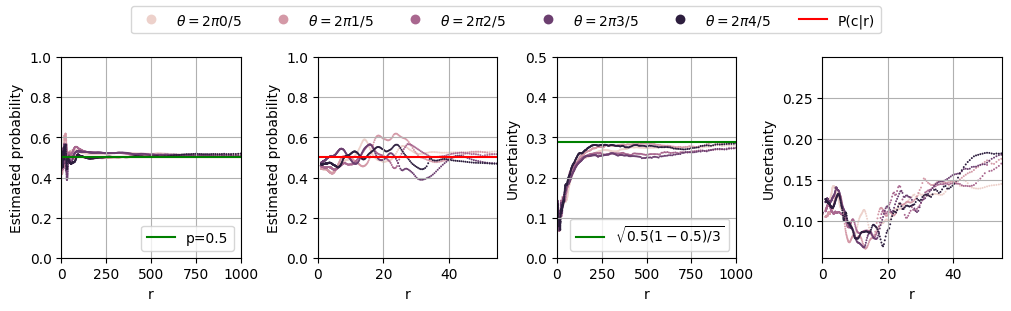

In [19]:
def plot_large_grid(df, df_truth, prob_key, err_key):

    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3), layout="constrained")

    #Plot estimated probabilities
    sn.scatterplot(df, x="r", y=prob_key, hue="a1", ax=axs[0], s=2, linewidth=0, alpha=1, legend=False)
    sn.lineplot(df_truth[df_truth["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[0], color="red", legend=False)
    x = [0, large_grid_rmax]
    y = [0.5, 0.5]
    axs[0].plot(x, y, c="green", label=f"p=0.5")
    axs[0].legend(loc='lower right')
    axs[0].set_ylabel("Estimated probability", size=10)
    axs[0].set_xlim(0, large_grid_rmax)
    axs[0].set_ylim(0, 1)

    sn.scatterplot(df, x="r", y=prob_key, hue="a1", ax=axs[1], s=2, alpha=1, linewidth=0, legend="full")
    sn.lineplot(df_truth[df_truth["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[1], label="P(c|r)", color="red")
    axs[1].set_ylabel("Estimated probability", size=10)
    axs[1].set_xlim(0, grid_rmax)
    axs[1].set_ylim(0, 1)

    #Plot uncertainties
    sn.scatterplot(df, x="r", y=err_key, hue="a1", ax=axs[2], s=2, linewidth=0, alpha=1, legend=False)
    x = [0, large_grid_rmax]
    #df_large_r = df.copy()[df["r"] > 700]
    #sigma = np.sqrt((df_large_r[prob_key].mean())*(1-df_large_r[prob_key].mean())/3)
    sigma = np.sqrt(0.5*(1-0.5)/3)
    y = [sigma, sigma]
    axs[2].plot(x, y, c="green", label=r"$\sqrt{0.5(1-0.5)/3}$")
    axs[2].legend(loc='lower right')
    axs[2].set_ylabel("Uncertainty", size=10)
    axs[2].set_ylim(0, 0.5)
    axs[2].set_xlim(0, large_grid_rmax)

    sn.scatterplot(df, x="r", y=err_key, hue="a1", ax=axs[3], s=2, linewidth=0, alpha=1, legend=False)
    axs[3].set_ylabel("Uncertainty", size=10)
    axs[3].set_xlim(0, grid_rmax)
    #axs[3].set_ylim(0, 1)

    handles, labels = axs[1].get_legend_handles_labels()
    len_labels = len(labels) - 1
    for i in range(len_labels):
        labels[i] = rf"$\theta = 2\pi${i}/5"
    axs[1].get_legend().remove()
    
    for ax in axs:
        ax.grid(True)
    
    fig.suptitle("    ", fontsize=26)
    fig.legend(handles, labels, loc='upper center', ncol=len_labels+1, labelspacing=0.1, fontsize=10, markerscale=5)

for i in range(len(n_data)):
    plot_large_grid(large_grid_dfs[i], large_grid_data, "Est_prob_c1", "Std_prob_c1")

### Plot training data and distributions

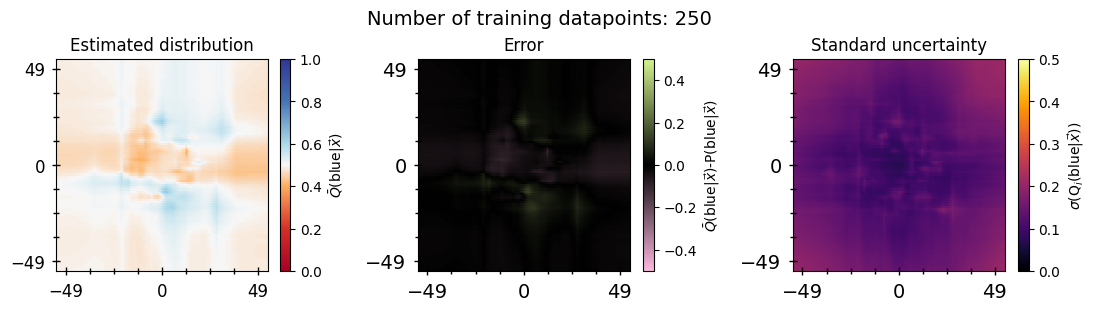

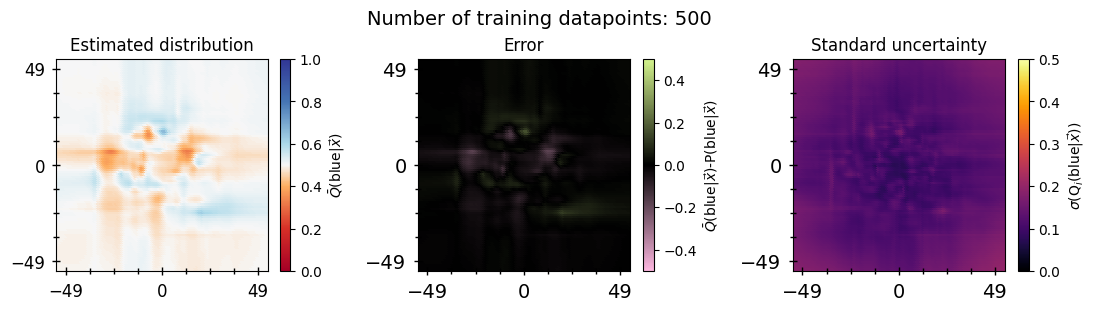

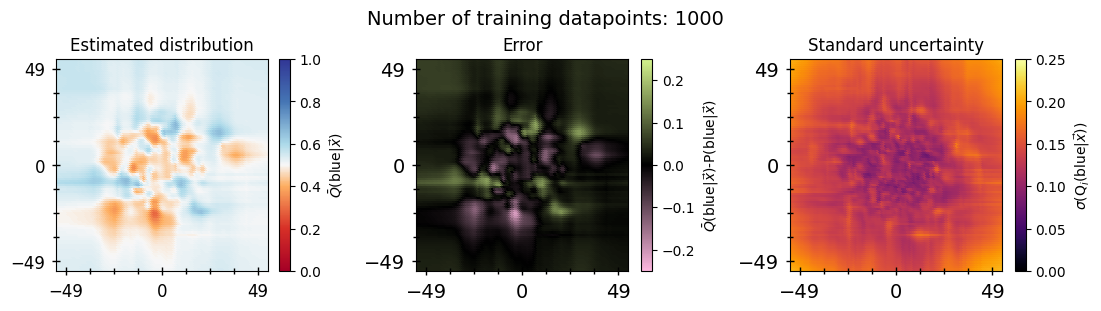

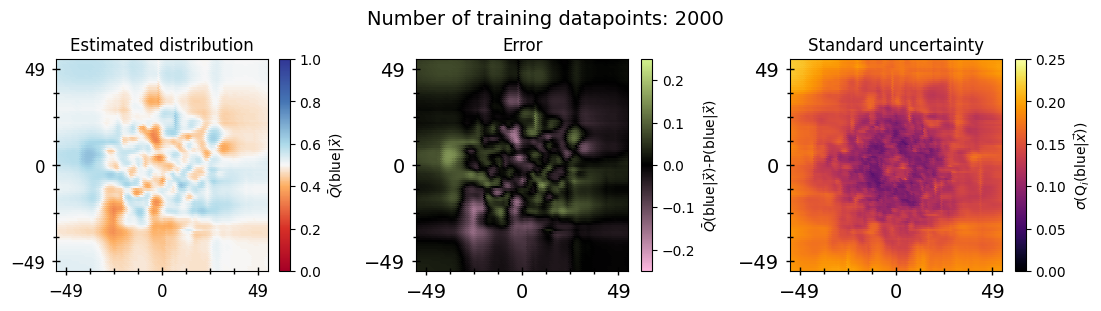

In [14]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_dfs[i], "Est_prob_c1", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], grid_data, "Est_prob_c1", "p_c1_given_r", axs[1], r"Error", max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_prob_c1", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, 
                 label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/mixture_model_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)


### Results from inference

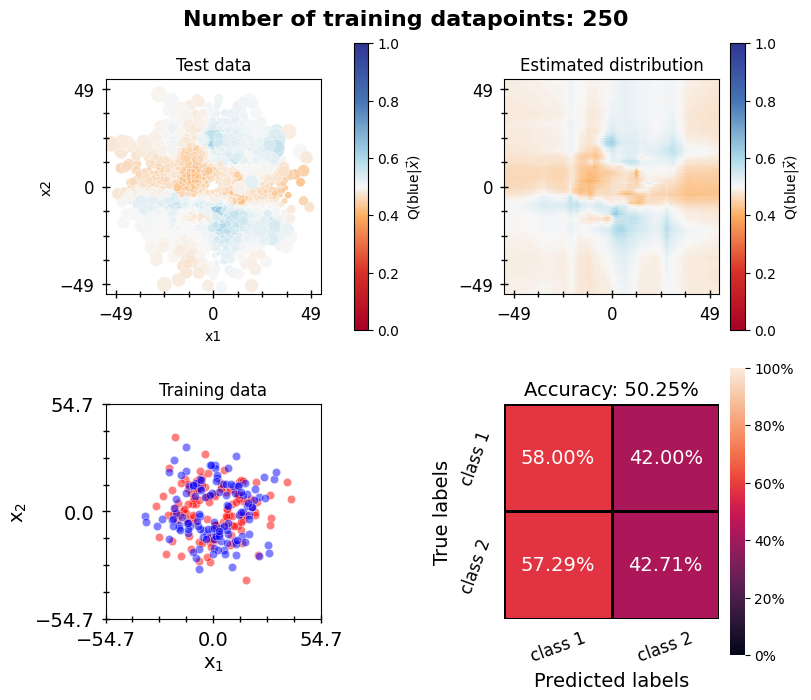

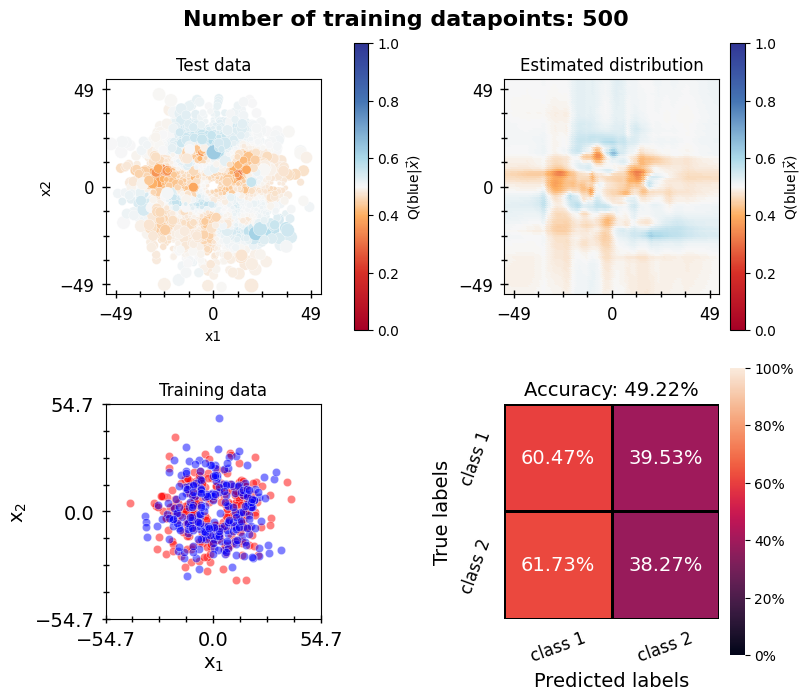

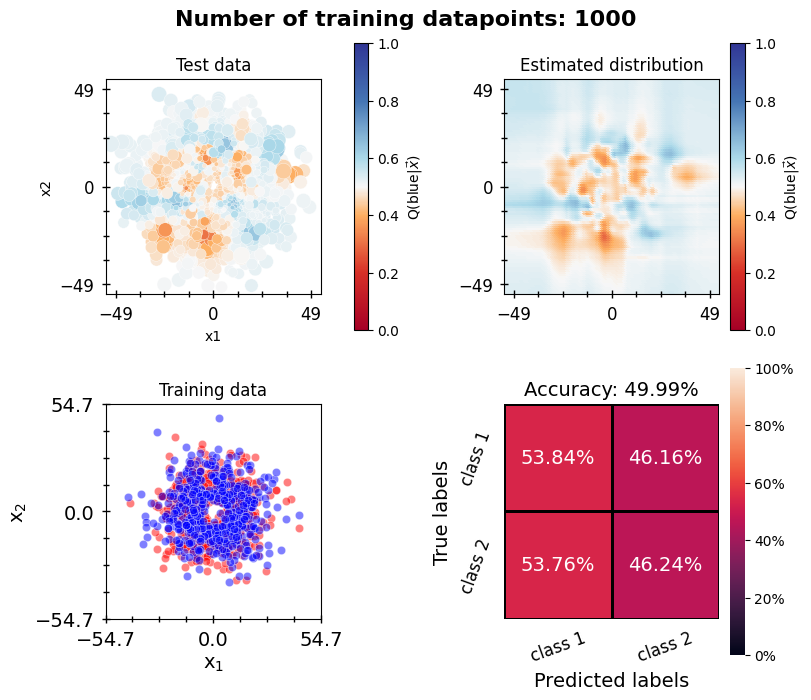

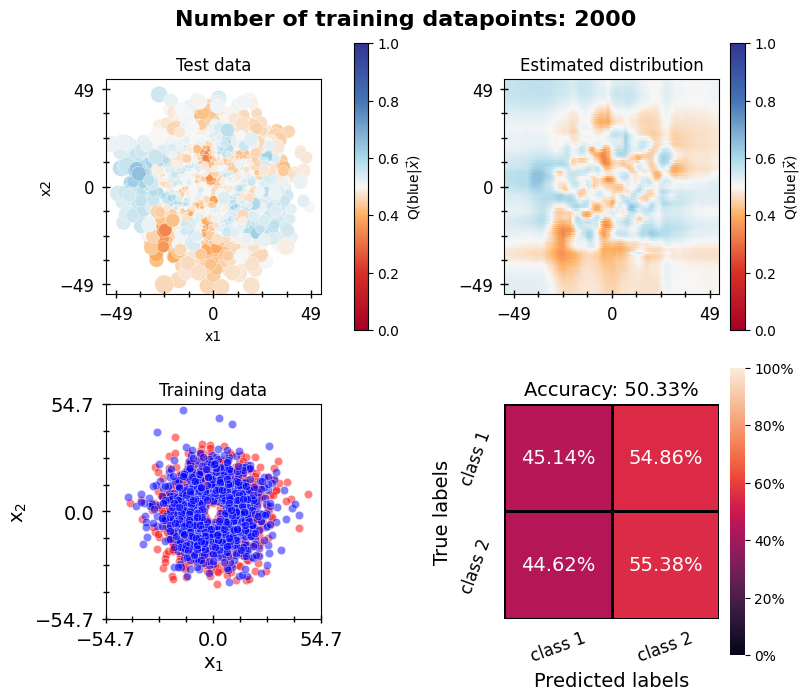

In [15]:

# Plot results

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_results(test_dfs[i], "Est_prob_c1", axs[0][0], "Test data", error_key="Std_prob_c1", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_dfs[i], "Est_prob_c1", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data", rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction", ["class 1", "class 2"], axs[1][1])
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")
    #plt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

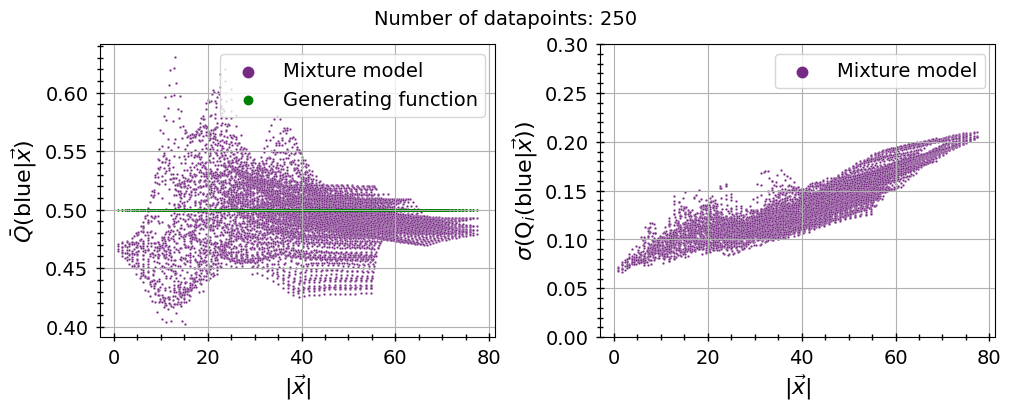

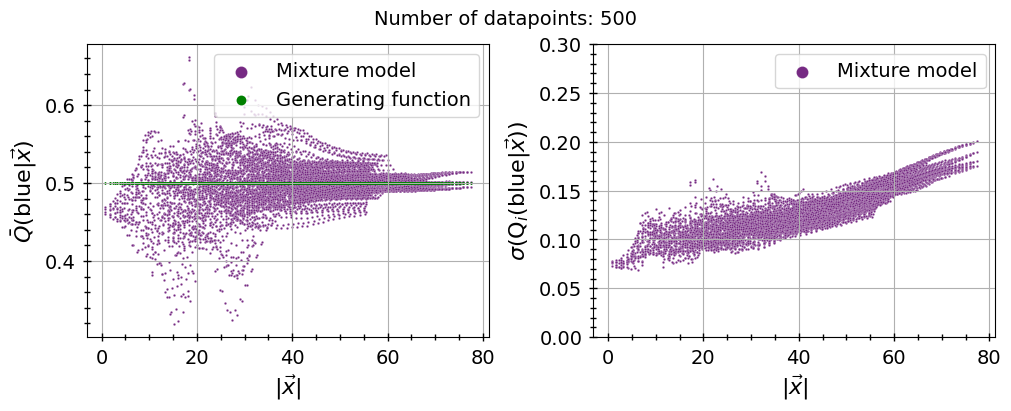

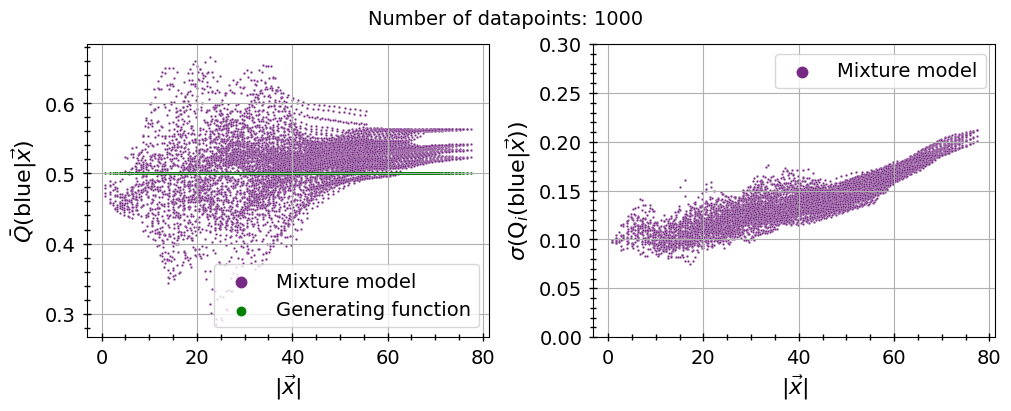

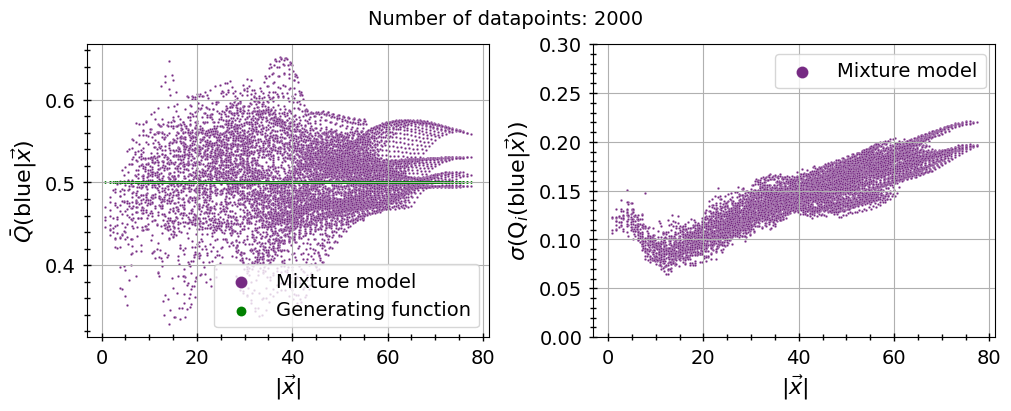

In [16]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r", y="Est_prob_c1", s=3, ax = axs[0], label="Mixture model", color="#762a83")
    #sn.lineplot(truth_data, x="r_x", y="P_c1_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(grid_data, x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function", color="green", linewidth=0)
    axs[0].set_ylabel(r"$\bar{Q}$(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r", y="Std_prob_c1", s=3, ax = axs[1], label="Mixture model", color="#762a83")
    axs[1].set_ylabel(r"$\sigma$(Q$_i$(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)


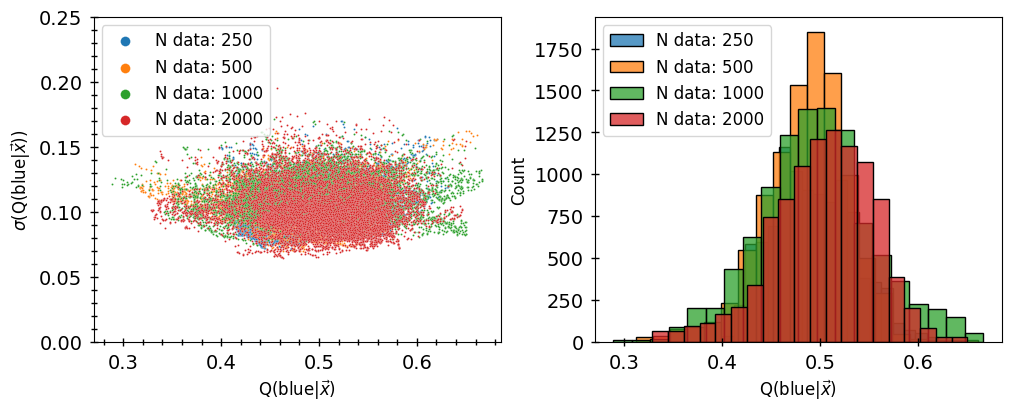

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Est_prob_c1", y="Std_prob_c1", s=2, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="Est_prob_c1", label=f"N data: {n_data[i]}", ax = axs[1], edgecolor="black", linewidth=1, bins=20)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

### Calibration

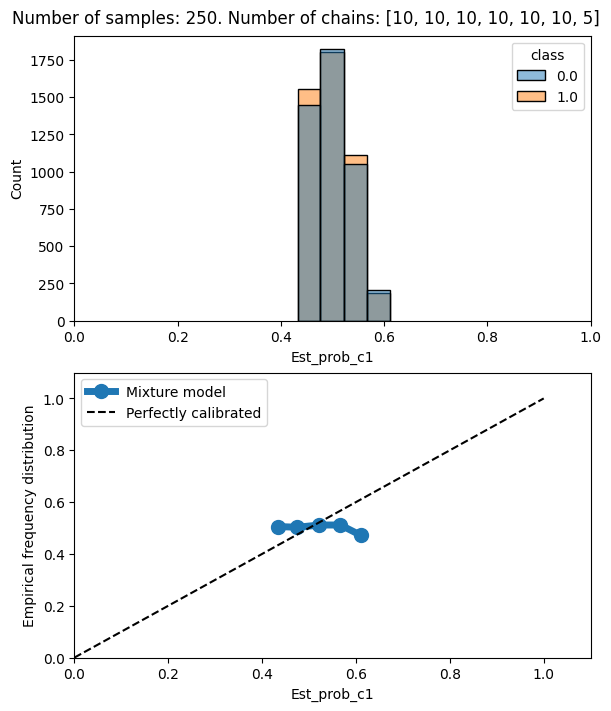

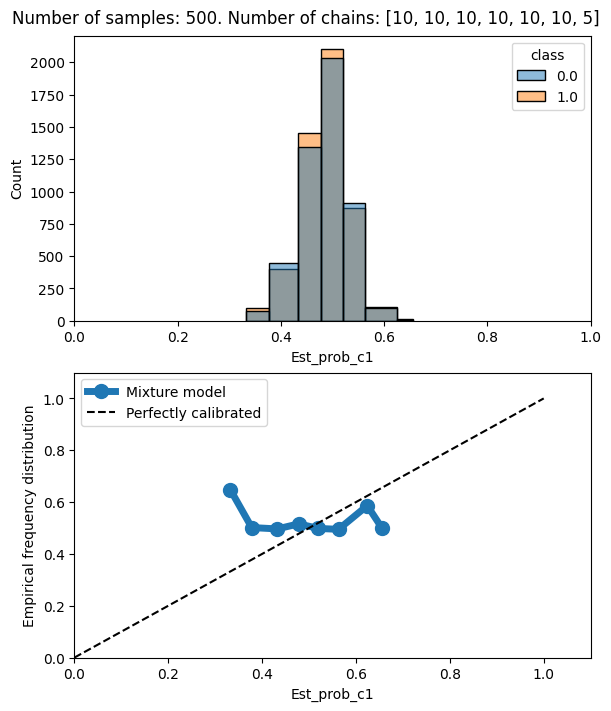

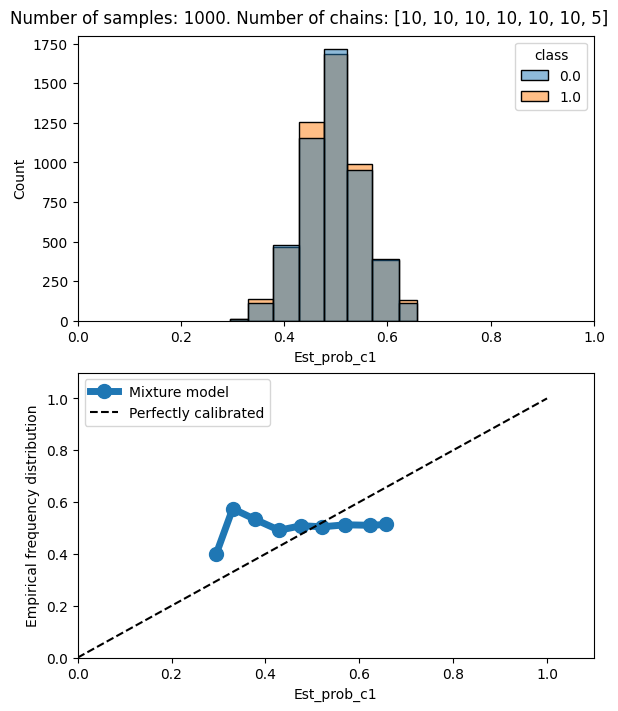

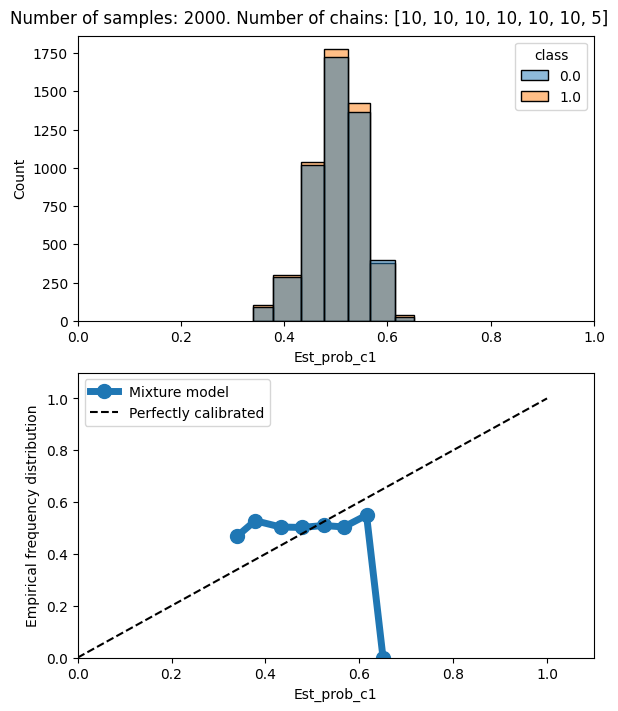

In [18]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(n_plots):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["class"], test_dfs[i]["Est_prob_c1"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="Est_prob_c1", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="Mixture model")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("Est_prob_c1")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of samples: {n_data[i]}. Number of chains: {n_chains}")